In [20]:
from pathlib import Path
import json
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

from scripts.dataset.dataloader import SemEvalTask8, collate_fn
from scripts.models.lstmer import LSTMER

from scripts.utils.test_utils import get_predictions, decode_vocab
from scripts.utils.test_utils import write_results, calculate_scores
from scripts.utils.utils import seed_everything, plot_bar, plot_hist
from scripts.utils.gpu_cuda_helper import select_device

import warnings
from dgl.base import DGLWarning

warnings.simplefilter("ignore", DGLWarning)


In [21]:
seed = 9001
seed_everything(seed)


In [22]:
ds_dir = "dataset/semeval_task8/processed/"
tree_type = ["shortest_path", "full_tree"]
config_path = "scripts/config.json"
checkpoints_dir = Path("/srv/data/zarzouram/lt2011/checkpoints/")
answer_dir = Path("dataset/semeval_task8/processed/").resolve().expanduser()
answer_keys_path = Path(
    "dataset/semeval_task8/processed/answer_keys.txt").resolve().expanduser()
scorer_path = Path(
    "dataset/semeval_task8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl"  # noqa: E501
).resolve().expanduser()  # noqa: E501

checkpoints = {
    tree_type[0]: str(checkpoints_dir / "1005.0200/checkpoint_best.pth.tar"),
    tree_type[1]: str(checkpoints_dir / "1005.0359/checkpoint_best.pth.tar")
}


In [23]:
train_data = torch.load(Path(ds_dir) / "raw_train.pt")
val_data = torch.load(Path(ds_dir) / "raw_val.pt")
test_data = torch.load(Path(ds_dir) / "raw_test.pt")

_, _, ents_trn, _, dep_trn, _, _, _, _, rel_trn, dir_trn = train_data
_, _, ents_val, _, dep_val, _, _, _, _, rel_val, dir_val = val_data
_, _, ents_tst, _, dep_tst, _, _, _, _, rel_tst, dir_tst = test_data


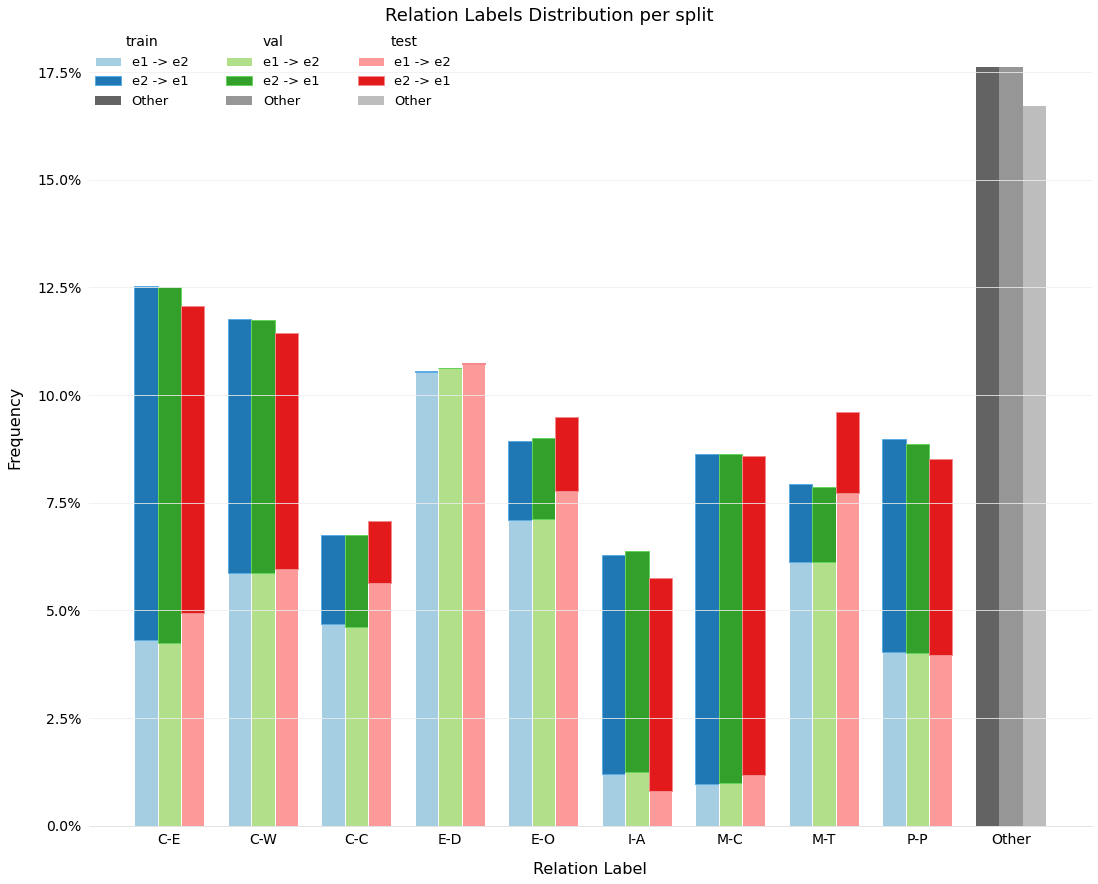

In [24]:
_ = plot_bar(rel=[rel_trn, rel_val, rel_tst], dir=[dir_trn, dir_val, dir_tst])


In [25]:
vocabs = torch.load(Path(ds_dir) / "vocabs.pt")
pad_values = {
    "token_pad_value": vocabs["tokens"]["<pad>"],
    "pos_pad_value": vocabs["pos"]["<pad>"],
    "dep_pad_value": vocabs["dep"]["<pad>"],
    "entl_pad_value": vocabs["ents"]["<pad>"]
}
vocab_sizes = {
    "token_vocab_sz": len(vocabs["tokens"]),
    "pos_vocab_sz": len(vocabs["pos"]),
    "dep_vocab_sz": len(vocabs["dep"]),
    "entl_vocab_sz": len(vocabs["ents"]),
    "rel_num": len(vocabs["rels"])
}

train_ds = SemEvalTask8(Path(ds_dir) / "train.pt")
val_ds = SemEvalTask8(Path(ds_dir) / "val.pt")
test_ds = SemEvalTask8(Path(ds_dir) / "test.pt")


In [26]:
device = select_device("gpu")
print(f"selected device is {device}.\n")



 cuda id   Memory usage  
    0          0.02%     
    1          7.09%     
    2          7.83%     
    3          7.83%     
selected device is cuda:0.



In [27]:
# load confuguration file
with open(config_path, "r") as f:
    config = json.load(f)
e1_tag = config["dataset"]["tags"]["ent"]["e1"]
e2_tag = config["dataset"]["tags"]["ent"]["e2"]
es_tag = [vocabs["ents"][e1_tag], vocabs["ents"][e2_tag]]


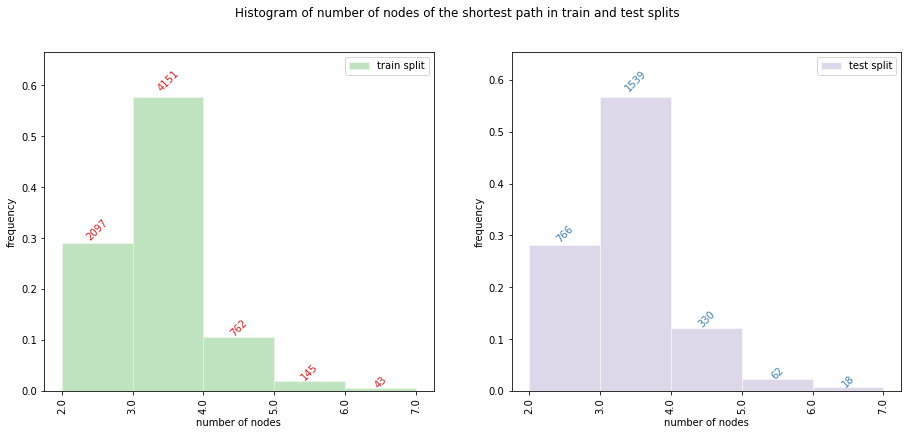

In [28]:
train_loader = DataLoader(train_ds,
                          batch_size=len(train_ds),
                          shuffle=False,
                          collate_fn=collate_fn(list(pad_values.values()),
                                                "shortest_path"))
test_loader = DataLoader(test_ds,
                         batch_size=len(test_ds),
                         shuffle=False,
                         collate_fn=collate_fn(list(pad_values.values()),
                                               "shortest_path"))

num_nodes = []
dep_tags = []
rels = []
ent_dep = []
for data_loader in [train_loader, test_loader]:
    count = 0
    for batch in data_loader:
        num_nodes.append(batch[6]._batch_num_nodes["_N"])
        dep_tags.append(batch[4])
        rels.append(batch[-2])
        idx0 = torch.repeat_interleave(torch.arange(num_nodes[-1].size(0)),
                                       num_nodes[-1])
        tokens_idx = batch[6].ndata["ID"]
        ent_dep.append(
            torch.split(dep_tags[-1][idx0, tokens_idx],
                        num_nodes[-1].tolist()))

title = "Histogram of number of nodes of the shortest path in train and test splits "
label_x = "number of nodes"
label_y = "frequency"
label_hist = ["train split", "test split"]
fig_data = {
    "label_h": label_hist,
    "xlabel": label_x,
    "ylabel": label_y,
    "title": title
}

figs, axes = plot_hist(data=[nn.tolist() for nn in num_nodes],
                       fig_data=fig_data,
                       bins=[
                           list(range(2, max(num_nodes[0]))),
                           list(range(2, max(num_nodes[1])))
                       ],
                       count=True)


In [29]:
from IPython.display import display, clear_output, HTML
import pandas as pd
import numpy as np

idx = torch.nonzero(num_nodes[0] == 2)
dep = torch.stack([ent_dep[0][i] for i in idx])
rel = rels[0][num_nodes[0] == 2]
dep0, dep1 = dep[:, 0], dep[:, 1]

dep0 = vocabs["dep"].lookup_tokens(dep0.tolist())
dep1 = vocabs["dep"].lookup_tokens(dep1.tolist())
rel = vocabs["rels"].lookup_tokens(rel.tolist())

rel_labels = sorted(vocabs["rels"].get_itos())
dep_label = np.unique(np.array(dep0))

df = pd.DataFrame({
    "rel": rel,
    "dep_0": dep0,
    "dep_1": dep1,
})

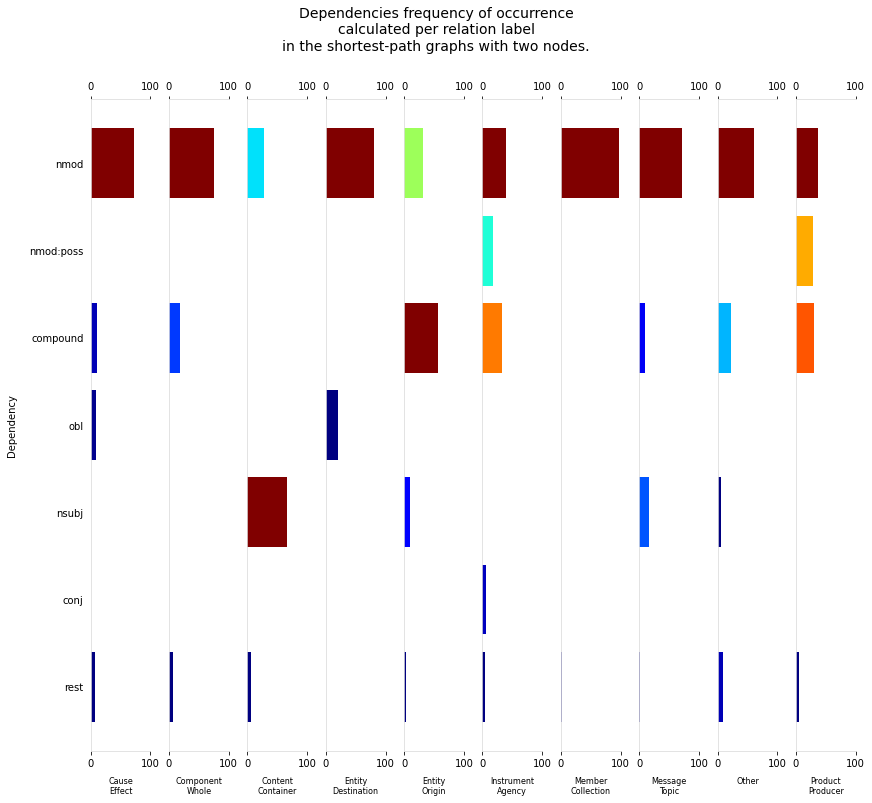

In [30]:
import matplotlib
import matplotlib.pyplot as plt

df_reldep = df.groupby(["rel", "dep_0"])["dep_0"].agg("count")
df_reldep = df_reldep.to_frame(name="count")
df_reldep["percent"] = df_reldep.groupby(
    level=0).transform(lambda x: x / sum(x) * 100).round(2)
df_reldep = df_reldep.reset_index()
df_rest_ids = df_reldep[df_reldep["percent"] < 5.].index
df_reldep.loc[df_rest_ids, "dep_0"] = "rest"

df_reldep = df_reldep.groupby(["rel", "dep_0"]).sum()

fig = plt.figure(figsize=(12, 10), constrained_layout=True)
spec = fig.add_gridspec(ncols=len(rel_labels), nrows=1)
fig.suptitle("Dependencies frequency of occurrence\ncalculated per relation label\nin the shortest-path graphs with two nodes.", fontsize=14, y=1.1)

df_reldep = df_reldep.reset_index().sort_values(by=["percent", "dep_0"])
dep_sorted_map = dict.fromkeys(df_reldep["dep_0"].astype(str).values.tolist())
dep_sorted_map.update((k, i) for i, k in enumerate(dep_sorted_map))

cmap = matplotlib.cm.get_cmap("jet")

axes = []
for c, r in enumerate(rel_labels):
    ax = fig.add_subplot(spec[0, c])
    axes.append(ax)
    df_r = df_reldep[df_reldep["rel"] == r]
    dep_tags = df_r["dep_0"].astype(str).values.tolist()
    values = df_r["percent"].astype(float).values.tolist()

    values_sorted = [0.] * len(dep_sorted_map)
    for d, v in zip(dep_tags, values):
        idx = dep_sorted_map[d]
        values_sorted[idx] = v

    y_ticks = list(dep_sorted_map.values())
    norm = matplotlib.colors.Normalize(vmin=min(values), vmax=max(values))

    bar = axes[-1].barh(y_ticks,
                        values_sorted,
                        color=[cmap(norm(v)) for v in values_sorted])
    _ = axes[-1].spines["top"].set_color("#DDDDDD")
    _ = axes[-1].spines["right"].set_visible(False)
    _ = axes[-1].spines["left"].set_color("#DDDDDD")
    _ = axes[-1].spines["bottom"].set_color("#DDDDDD")
    _ = axes[-1].yaxis.grid(False)
    _ = axes[-1].xaxis.grid(False)
    _ = axes[-1].set_xlim(0, 100)
    _ = axes[-1].xaxis.set_tick_params(labeltop=True)

    xlabel = r if r == "Other" else "\n".join(r.split("-"))
    _ = axes[-1].set_xlabel(xlabel, labelpad=8, fontsize=8)

    if c == 0:
        _ = axes[0].set_yticks(y_ticks)
        _ = axes[0].set_yticklabels(list(dep_sorted_map.keys()))
        _ = axes[0].set_ylabel("Dependency", labelpad=12, fontsize=10)
        _ = axes[0].tick_params(bottom=True, left=False, top=True)
    else:
        _ = axes[-1].tick_params(bottom=True, left=False, top=True)
        _ = axes[-1].set_yticklabels([])


In [12]:
# df_rel = df.groupby(["rel", "dep_0", "dep_1"])["dep_1"].agg("count")
# df_rel = df_rel.to_frame(name="count")
# df_rel["percent"] = df_rel.groupby(
#     level=0).transform(lambda x: x / sum(x) * 100).round(2)
# df_rel = df_rel.reset_index()
# df_rest_ids = df_rel[df_rel["percent"] < 5.].index
# df_rel.loc[df_rest_ids, ["dep_0", "dep_1"]] = "rest"

# df_rel = df_rel.groupby(["rel", "dep_0", "dep_1"]).sum()

# df_dep = df.groupby(["dep_0", "rel", "dep_1"])["dep_1"].agg("count")
# df_dep = df_dep.to_frame(name="count")
# df_dep["percent"] = df_dep.groupby(
#     level=0).transform(lambda x: x / sum(x) * 100).round(2)
# df_dep = df_dep.reset_index()
# df_rest_ids = df_dep[df_dep["percent"] < 5.].index
# df_dep.loc[df_rest_ids, ["rel", "dep_1"]] = "rest"

# df_dep = df_dep.groupby(["dep_0", "rel", "dep_1"]).sum()

# display(HTML(df["percent"].loc[:, "nmod"].to_frame().to_html()))
# df_dep["percent"].loc["nsubj"].unstack().plot(kind='bar', stacked=True)

In [13]:
# import ipywidgets as widgets
# import numpy as np

# dep0_label = np.unique(np.array(dep0))

# out_plot = widgets.Output()
# out_df = widgets.Output(
#     layout=widgets.Layout(height="100%", width="30%", border="solid"))


# def f(*args):
#     out_plot.clear_output()
#     with out_plot:
#         clear_output()
#         fig, ax = plt.subplots(figsize=(6, 4))
#         fig.show()


# filter_dropdown = widgets.Dropdown(
#     value="",
#     options=["", "Relation Labels", "Node 0 Dependency"],
#     description="Filter by")

# focus_dropdown = widgets.Dropdown(disabled=True,
#                                   options=[],
#                                   description="Select an item")


# def filter_selected(change):
#     if change.new != "":
#         focus_dropdown.disabled = False
#         if change.new == "Relation Labels":
#             focus_dropdown.options = rel_labels
#         else:
#             focus_dropdown.options = dep0_label

#     else:
#         focus_dropdown.options = []
#         focus_dropdown.disabled = True


# filter_dropdown.observe(filter_selected, "value")

# user_interact_form = widgets.VBox([filter_dropdown, focus_dropdown, out_plot],
#                                   layout=widgets.Layout(height="100%",
#                                                         width="70%",
#                                                         border="solid"))
# form = widgets.HBox([user_interact_form, out_df])
# display(form)

In [14]:
results = {}
neg_rel = vocabs["rels"]["Other"]
dir_ids = [
    vocabs["rel_dir"]["ndir"], vocabs["rel_dir"]["(e1,e2)"],
    vocabs["rel_dir"]["(e2,e1)"]
]
for t_type, path in checkpoints.items():

    data_loader = DataLoader(test_ds,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4,
                             collate_fn=collate_fn(list(pad_values.values()),
                                                   t_type))

    model_hyp = config["model_hyperp"]
    model_hyp["dep_tree"]["tree_type"] = t_type
    model = LSTMER(**vocab_sizes,
                   **pad_values,
                   **model_hyp["embeddings"],
                   **model_hyp["entity_detect"],
                   **model_hyp["dep_tree"],
                   **model_hyp["rel_extract"],
                   **model_hyp["modes"],
                   dropouts=model_hyp["dropouts"])

    # load checkpoint
    state = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(state["model"])
    model = model.to(device)

    model.eval()
    pb = tqdm(data_loader, total=len(data_loader), unit="step")
    ids = []
    rel_allpreds, dir_allpreds = [], []
    rel_alltargets, dir_alltargets = [], []
    for step, batch in enumerate(pb):
        # set progress bar description and metrics
        pb.set_description(f"Tree Type: {t_type}")
        with torch.no_grad():
            # move data to device
            batch = [b.to(device) for b in batch]
            logits_12, logits_21, *_ = model(batch, es_tag)
            rel_preds, dir_preds = get_predictions(logits_12, logits_21,
                                                   neg_rel, dir_ids)
            rel_targets, dir_targets = batch[-2:]
            ids.append(batch[0])
            rel_allpreds.append(rel_preds)
            dir_allpreds.append(dir_preds)
            rel_alltargets.append(rel_targets)
            dir_alltargets.append(dir_targets)

    ids = torch.cat(ids).tolist()
    rel_allpreds = torch.cat(rel_allpreds).tolist()
    dir_allpreds = torch.cat(dir_allpreds).tolist()

    rel_preds_str = decode_vocab(vocabs["rels"], rel_allpreds)
    dir_preds_str = decode_vocab(vocabs["rel_dir"], dir_allpreds)

    answer_path = str(answer_dir / f"{t_type}_answers.txt")
    write_results(ids, rel_preds_str, dir_preds_str, answer_path)
    p, r, f1, acc, scores, result = calculate_scores(str(scorer_path),
                                                     answer_path,
                                                     str(answer_keys_path))

    results[t_type] = {
        "f1": f1,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "scores": scores,
        "result": result
    }

  0%|          | 0/2716 [00:00<?, ?step/s]

  0%|          | 0/2716 [00:00<?, ?step/s]

In [15]:
for t_type in results:
    print(
        f"{t_type:15s}: f1_score: {results[t_type]['f1']:.2f}%, Precision: {results[t_type]['precision']}%, Recall: {results[t_type]['recall']}%"
    )


shortest_path  : f1_score: 76.30%, Precision: 76.52%, Recall: 76.35%
full_tree      : f1_score: 75.26%, Precision: 75.79%, Recall: 75.07%


In [16]:
labels = results["full_tree"]["scores"].keys()
scores = {
    label: {
        ("p", t): 0,
        ("r", t): 0,
        ("f1", t): 0
    }
    for label in labels for t in results.keys()
}
for t_type, scores_dict in results.items():
    for label, (p, r, f) in scores_dict["scores"].items():
        scores[label][("p", t_type)] = p
        scores[label][("r", t_type)] = r
        scores[label][("f1", t_type)] = f

scores_new = {}
for label, scores_dict in scores.items():
    keys_sorted = sorted(list(scores_dict.keys()), key=lambda x: x[0])
    scores_dict_sorted = {k: scores_dict[k] for k in keys_sorted}
    scores_new[label] = scores_dict_sorted

df = pd.DataFrame.from_dict(scores_new, orient="index")
display(df)


f1                       p                       r  \
                   full_tree shortest_path full_tree shortest_path full_tree   
Cause-Effect           84.24         87.38     86.26         90.52     82.32   
Component-Whole        71.36         68.50     71.02         68.83     71.70   
Content-Container      80.58         83.13     75.45         78.34     86.46   
Entity-Destination     85.23         86.45     83.55         81.71     86.99   
Entity-Origin          82.40         78.75     79.71         79.22     85.27   
Instrument-Agency      56.34         63.95     62.50         68.12     51.28   
Member-Collection      77.61         79.75     77.12         77.64     78.11   
Message-Topic          74.07         73.60     80.00         76.99     68.97   
Product-Producer       65.49         65.18     66.52         67.28     64.50   
_Other                 39.57         36.68     38.66         36.36     40.53   

                                  
                   shortest_path  
Cause-Effect               84.45  
Component-Whole            68.17  
Content-Container          88.54  
Entity-Destination         91.78  
Entity-Origin              78.29  
Instrument-Agency          60.26  
Member-Collection          81.97  
Message-Topic              70.50  
Product-Producer           63.20  
_Other                     37.00

In [17]:
print("\n".join(results["full_tree"]["result"].strip().split("\n")[:15]))

Confusion matrix:
         C-E  C-W  C-C  E-D  E-O  I-A  M-C  M-T  P-P  _O_ <-- classified as
      +--------------------------------------------------+ -SUM- xDIRx skip  ACTUAL
  C-E | 270    1    1    1   12    0    0    0    7   33 |  325     3     0    328
  C-W |   3  223    5    0    2    6   14    6    5   44 |  308     3     0    311
  C-C |   0    5  166    7    3    1    0    1    0    8 |  191     1     0    192
  E-D |   1    3    9  254    0    1    0    2    1   21 |  292     0     0    292
  E-O |   5    3    0    3  220    1    0    1    2   23 |  258     0     0    258
  I-A |   4   17    2    1    3   80    1    1   12   33 |  154     2     0    156
  M-C |   2    6    0    1    2    1  182    1    4   33 |  232     1     0    233
  M-T |   0    5    3    2    1    3    2  180    7   58 |  261     0     0    261
  P-P |   8    8    1    2    4   11    3    3  149   39 |  228     3     0    231
  _O_ |  17   40   32   33   29   22   33   30   34  184 |  454     0     0

In [18]:
print("\n".join(results["shortest_path"]["result"].strip().split("\n")[:15]))

Confusion matrix:
         C-E  C-W  C-C  E-D  E-O  I-A  M-C  M-T  P-P  _O_ <-- classified as
      +--------------------------------------------------+ -SUM- xDIRx skip  ACTUAL
  C-E | 277    3    0    1    6    0    0    3    5   32 |  327     1     0    328
  C-W |   1  212    5    2    4   11   11    6    4   53 |  309     2     0    311
  C-C |   0    1  170    3    2    1    1    1    0    9 |  188     4     0    192
  E-D |   0    1    7  268    0    0    0    1    1   13 |  291     1     0    292
  E-O |   6    4    1    4  202    0    0    1    3   37 |  258     0     0    258
  I-A |   0   12    0    3    4   94    0    1   13   29 |  156     0     0    156
  M-C |   0   10    0    0    1    0  191    1    3   26 |  232     1     0    233
  M-T |   0    7    4    3    2    2    2  184    5   51 |  260     1     0    261
  P-P |   5    9    1    2    6    9    3    3  146   44 |  228     3     0    231
  _O_ |  16   47   25   41   28   21   37   37   34  168 |  454     0     0